In [136]:
import pandas as pd
from typing import Any
import pandas as pd
import datetime as dt

from transforms.cleaner import (
    clean_column_names,
    normalize_missing_values,
    clean_amount_column,
    parse_dates,
    date_analysis,
    canonical_investment_type,
    split_investors,
    clean_startup_name, 
    normalize_city
)

from transforms.analysis import (
    detect_amount_outliers,
    amount_stats_summary,
    bucketize_amount
)
import re

In [137]:
df = pd.read_csv('/Users/olixstudios/Documents/workspace/Projects/indian-startups-transformations/data/starup.csv')
first_column_name = df.columns[0]
df = df.drop(columns=[first_column_name], errors="ignore")

In [138]:
df

,Date,Startup,Industry,Location,Investor,Type,Amount
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,"46,00,00,000"
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,"30,00,00,000"
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,"34,30,00,000"
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,"8,30,00,000"
4,14-04-2021,Beldara,E-commerce,Mumbai,Hindustan Media Ventures,Venture,"74,00,000"
...,...,...,...,...,...,...,...
611,26-07-2018,TheCapitalNet,Fin-Tech,Hyderabad,Lindwall Family Investments LLC (LFI),Private Equity,"5,00,000"
612,30-07-2018,Shuttl,Consumer Internet,Gurugram,Amazon Alexa Fund & Dentsu Ventures,Private Equity,"1,10,00,000"
613,30-07-2018,Cure Fit,Consumer Internet,Bengaluru,"IDG Ventures, Accel Partners, Kalaari Capital ...",Private Equity,"12,00,00,000"
614,31-07-2018,Five Star Group,Fin-Tech,Chennai,"TPG, Norwest Venture Partners, Sequoia Capital...",Private Equity,"10,00,00,000"


In [139]:
# compute z 
def compute_z_score(series: pd.Series) -> pd.Series:
    mean = series.mean()
    std = series.std()
    return (series - mean) / std
df = clean_amount_column(df, 'Amount')
# Compute z-score
df['z_score'] = compute_z_score(df['Amount'])
df

,Date,Startup,Industry,Location,Investor,Type,Amount,z_score
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,460000000.0,2.116215
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,300000000.0,1.298303
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,343000000.0,1.518117
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,83000000.0,0.189010
4,14-04-2021,Beldara,E-commerce,Mumbai,Hindustan Media Ventures,Venture,7400000.0,-0.197453
...,...,...,...,...,...,...,...,...
611,26-07-2018,TheCapitalNet,Fin-Tech,Hyderabad,Lindwall Family Investments LLC (LFI),Private Equity,500000.0,-0.232726
612,30-07-2018,Shuttl,Consumer Internet,Gurugram,Amazon Alexa Fund & Dentsu Ventures,Private Equity,11000000.0,-0.179050
613,30-07-2018,Cure Fit,Consumer Internet,Bengaluru,"IDG Ventures, Accel Partners, Kalaari Capital ...",Private Equity,120000000.0,0.378152
614,31-07-2018,Five Star Group,Fin-Tech,Chennai,"TPG, Norwest Venture Partners, Sequoia Capital...",Private Equity,100000000.0,0.275913


In [140]:
df['zscore_outlier'] = df['z_score'].abs() > 3
df

,Date,Startup,Industry,Location,Investor,Type,Amount,z_score,zscore_outlier
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,460000000.0,2.116215,False
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,300000000.0,1.298303,False
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,343000000.0,1.518117,False
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,83000000.0,0.189010,False
4,14-04-2021,Beldara,E-commerce,Mumbai,Hindustan Media Ventures,Venture,7400000.0,-0.197453,False
...,...,...,...,...,...,...,...,...,...
611,26-07-2018,TheCapitalNet,Fin-Tech,Hyderabad,Lindwall Family Investments LLC (LFI),Private Equity,500000.0,-0.232726,False
612,30-07-2018,Shuttl,Consumer Internet,Gurugram,Amazon Alexa Fund & Dentsu Ventures,Private Equity,11000000.0,-0.179050,False
613,30-07-2018,Cure Fit,Consumer Internet,Bengaluru,"IDG Ventures, Accel Partners, Kalaari Capital ...",Private Equity,120000000.0,0.378152,False
614,31-07-2018,Five Star Group,Fin-Tech,Chennai,"TPG, Norwest Venture Partners, Sequoia Capital...",Private Equity,100000000.0,0.275913,False


In [141]:
q1 = df['Amount'].quantile(0.25)
q3 = df['Amount'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df['iqr_outlier'] = (df['Amount'] < lower_bound) | (df['Amount'] > upper_bound)
df

,Date,Startup,Industry,Location,Investor,Type,Amount,z_score,zscore_outlier,iqr_outlier
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,460000000.0,2.116215,False,True
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,300000000.0,1.298303,False,True
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,343000000.0,1.518117,False,True
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,83000000.0,0.189010,False,True
4,14-04-2021,Beldara,E-commerce,Mumbai,Hindustan Media Ventures,Venture,7400000.0,-0.197453,False,False
...,...,...,...,...,...,...,...,...,...,...
611,26-07-2018,TheCapitalNet,Fin-Tech,Hyderabad,Lindwall Family Investments LLC (LFI),Private Equity,500000.0,-0.232726,False,False
612,30-07-2018,Shuttl,Consumer Internet,Gurugram,Amazon Alexa Fund & Dentsu Ventures,Private Equity,11000000.0,-0.179050,False,False
613,30-07-2018,Cure Fit,Consumer Internet,Bengaluru,"IDG Ventures, Accel Partners, Kalaari Capital ...",Private Equity,120000000.0,0.378152,False,True
614,31-07-2018,Five Star Group,Fin-Tech,Chennai,"TPG, Norwest Venture Partners, Sequoia Capital...",Private Equity,100000000.0,0.275913,False,True


In [142]:
df['is_outlier'] = df['zscore_outlier'] | df['iqr_outlier']
df

,Date,Startup,Industry,Location,Investor,Type,Amount,z_score,zscore_outlier,iqr_outlier,is_outlier
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,460000000.0,2.116215,False,True,True
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,300000000.0,1.298303,False,True,True
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,343000000.0,1.518117,False,True,True
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,83000000.0,0.189010,False,True,True
4,14-04-2021,Beldara,E-commerce,Mumbai,Hindustan Media Ventures,Venture,7400000.0,-0.197453,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
611,26-07-2018,TheCapitalNet,Fin-Tech,Hyderabad,Lindwall Family Investments LLC (LFI),Private Equity,500000.0,-0.232726,False,False,False
612,30-07-2018,Shuttl,Consumer Internet,Gurugram,Amazon Alexa Fund & Dentsu Ventures,Private Equity,11000000.0,-0.179050,False,False,False
613,30-07-2018,Cure Fit,Consumer Internet,Bengaluru,"IDG Ventures, Accel Partners, Kalaari Capital ...",Private Equity,120000000.0,0.378152,False,True,True
614,31-07-2018,Five Star Group,Fin-Tech,Chennai,"TPG, Norwest Venture Partners, Sequoia Capital...",Private Equity,100000000.0,0.275913,False,True,True


In [143]:
def amount_stats_summary(df: pd.DataFrame, column: str) -> pd.DataFrame:
    stats = {
        'mean': df[column].mean(),
        'median': df[column].median(),
        'std_dev': df[column].std(),
        'min': df[column].min(),
        'max': df[column].max(),
        'q1': df[column].quantile(0.25),
        'q3': df[column].quantile(0.75),
        'iqr': df[column].quantile(0.75) - df[column].quantile(0.25),
        'count_outliers': df['is_outlier'].sum(),
        'pct_outliers': df['is_outlier'].mean() * 100
    }
    return pd.DataFrame([stats])
summary_df = amount_stats_summary(df, 'Amount')
summary_df

,mean,median,std_dev,min,max,q1,q3,iqr,count_outliers,pct_outliers
0,4.602586e+07,6000000.0,1.956201e+08,114811.0,3.900000e+09,1625000.0,27125000.0,25500000.0,77,12.5


In [144]:
def detect_amount_outliers(df: pd.DataFrame, col: str = "amount") -> pd.DataFrame:
    df = df.copy()
    df = clean_column_names(df)
    df = clean_amount_column(df, col)
    
    def compute_z_score(series: pd.Series) -> pd.Series:
        series = df["amount"].dropna()
        mean = series.mean()
        std = series.std()
        return (series - mean) / std
    
    df['z_score'] = compute_z_score(df[col])
    df['zscore_outlier'] = df['z_score'].abs() > 3
    
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df['iqr_outlier'] = (df[col] < lower_bound) | (df[col] > upper_bound)
    
    df['is_outlier'] = df['zscore_outlier'] | df['iqr_outlier']
    
    return df

In [145]:
df = detect_amount_outliers(df)
amount_stats_summary(df, 'amount')

,mean,median,std_dev,min,max,q1,q3,iqr,count_outliers,pct_outliers
0,4.602586e+07,6000000.0,1.956201e+08,114811.0,3.900000e+09,1625000.0,27125000.0,25500000.0,77,12.5


,date,startup,industry,location,investor,type,amount,z_score,zscore_outlier,iqr_outlier,is_outlier
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,460000000.0,2.116215,False,True,True
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,300000000.0,1.298303,False,True,True
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,343000000.0,1.518117,False,True,True
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,83000000.0,0.189010,False,True,True
5,04-03-2021,DealShare,E-commerce,"Jaipur, Rajasthan",Innoven Capital,Debt Financing,250000000.0,1.042705,False,True,True


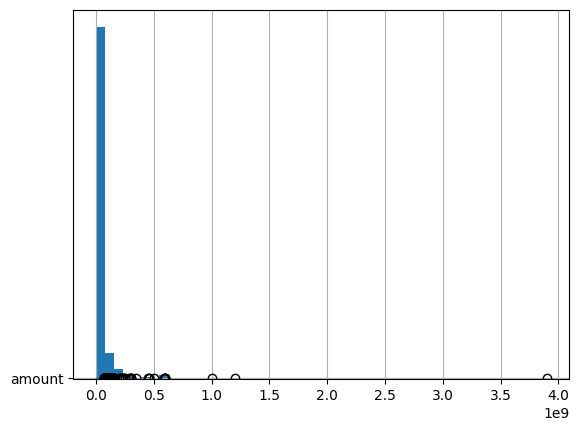

In [146]:
df['amount'].hist(bins=50)
df.boxplot(column='amount', vert=False)
df[df['is_outlier']].head()

In [147]:
def bucketize_amount(df: pd.DataFrame, col: str = "amount") -> pd.DataFrame:
    def bucket_amount_value(x: float) -> str:
        if pd.isna(x):
            return "unknown"
        if x <= 1e6:
            return "very_small"
        elif x <= 1e7:
            return "small"
        elif x <= 5e7:
            return "medium"
        elif x <= 2e8:
            return "large"
        elif x <= 5e8:
            return "very_large"
        else:
            return "mega"
    
    df = df.copy()
    df['amount_bucket'] = df[col].apply(bucket_amount_value)
    return df

In [148]:
df = bucketize_amount(df)
df['amount_bucket'].value_counts()

amount_bucket
small         218
medium        139
very_small    109
unknown        66
large          57
very_large     19
mega            8
Name: count, dtype: int64

<Axes: xlabel='amount_bucket'>

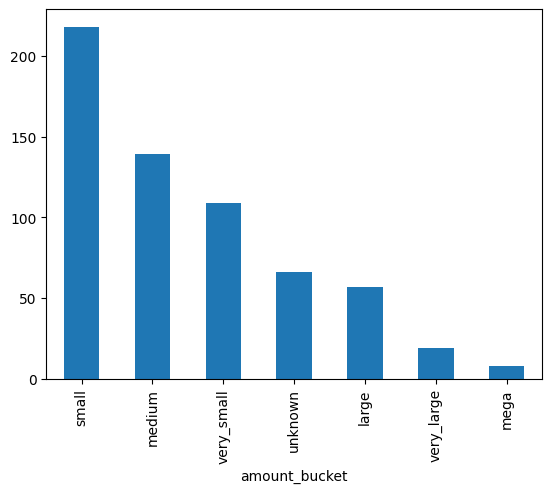

In [149]:
df['amount_bucket'].value_counts().plot(kind='bar')

Write 3–5 bullet points summarizing: <br>
	•	Which bucket dominates? - Small dominates clearly <br>
	•	How many megadeals exist? - 8 <br>
	•	Does the distribution support the long-tail funding hypothesis? yes, small number of deals fall into the very top buckets, but a large number of deals are in the lower buckets with small clearly dominating. 

### Histogram of amount

<Axes: >

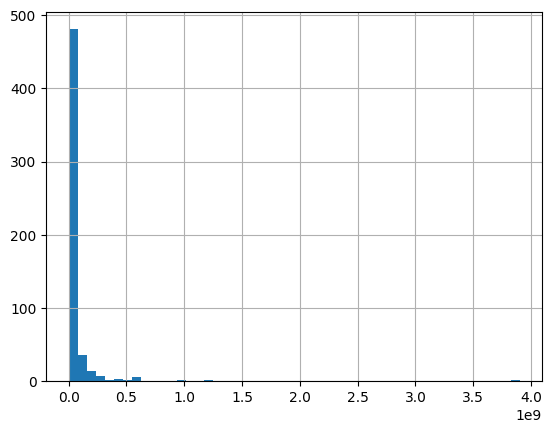

In [150]:
df['amount'].hist(bins=50)

### Boxplot of amount

<Axes: >

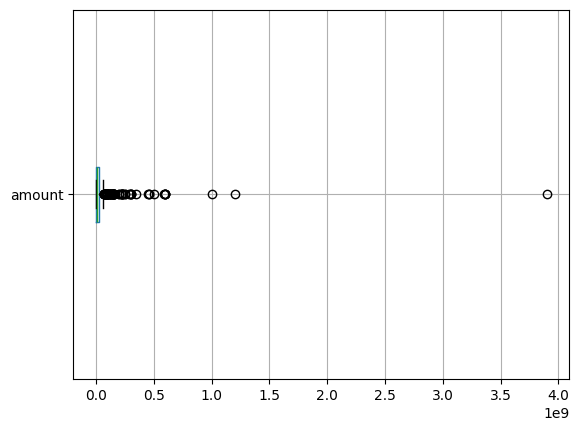

In [151]:
df.boxplot(column='amount', vert=False)

### preview of the outliers

In [152]:
df[df['is_outlier']].head(20)

,date,startup,industry,location,investor,type,amount,z_score,zscore_outlier,iqr_outlier,is_outlier,amount_bucket
0,01-04-2021,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,4.600000e+08,2.116215,False,True,True,very_large
1,05-04-2021,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,3.000000e+08,1.298303,False,True,True,very_large
2,14-04-2021,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,3.430000e+08,1.518117,False,True,True,very_large
3,07-04-2021,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,8.300000e+07,0.189010,False,True,True,large
5,04-03-2021,DealShare,E-commerce,"Jaipur, Rajasthan",Innoven Capital,Debt Financing,2.500000e+08,1.042705,False,True,True,very_large
6,31-03-2021,Uniphore,Technology,Palo Alto,Sorenson Capital Partners,Series D,1.400000e+08,0.480391,False,True,True,large
8,30-03-2021,BYJU'S,Edu-tech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series F,4.600000e+08,2.116215,False,True,True,very_large
9,23-03-2021,SkilloVilla,Edu-tech,Bengaluru,"Titan Capital, others",Seed,3.000000e+08,1.298303,False,True,True,very_large
13,22-02-2021,Zomato,Hospitality,Gurgaon,"Tiger Global, Kora",Venture,2.500000e+08,1.042705,False,True,True,very_large
16,15-02-2021,KreditBee,Finance,Bengaluru,Azim Premji’s PremjiInvest and South Korea’s M...,Series C,7.500000e+07,0.148114,False,True,True,large


## Industry and city summary tables

In [153]:
df['industry'].value_counts()

industry
Consumer Internet      148
Technology              47
Finance                 36
E-commerce              32
Healthcare              30
                      ... 
Lifestyle                1
Health and wellness      1
Industrial Robotics      1
Video                    1
Co-working Spaces        1
Name: count, Length: 125, dtype: int64

<Axes: ylabel='industry'>

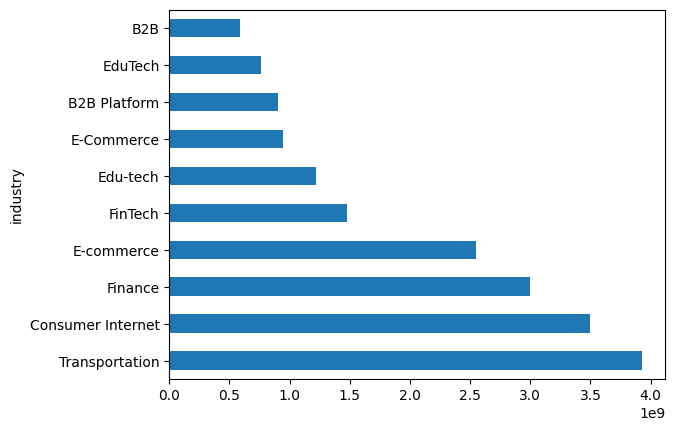

In [154]:
industry_grp = df.groupby('industry')['amount'].sum().sort_values(ascending=False).head(10)
industry_grp.plot(kind='barh')

In [155]:
# 1. Load the raw CSV
df = pd.read_csv("../data/starup.csv")

# ----------------------------------------
# CLEANING PIPELINE
# ----------------------------------------

# 2. Clean column names
df = clean_column_names(df)

# 3. Normalize missing textual values
df = normalize_missing_values(df)

# 4. Clean amount column (numeric conversion)
df = clean_amount_column(df, col="amount")

# 5. Parse date column
df = parse_dates(df, col="date")

# 6. Add date analysis fields (year, date_missing)
df = date_analysis(df, date_col="date")

# 7. Canonicalize investment type
df["type_canonical"] = canonical_investment_type(df["type"])

# 8. Split investors + investor count
df = split_investors(df, col="investor")

# 9. Clean startup names
df["startup_clean"] = df["startup"].apply(clean_startup_name)

# 10. Bucketize amount
df = bucketize_amount(df, col="amount")

# 11. Normalize city names
df['city_stand'] = normalize_city(df['location'])

# Keep only rows where city_stand is NOT empty
df = df[df["city_stand"] != ""]

# ----------------------------------------
# OUTLIER ANALYSIS
# ----------------------------------------

# 10. Detect outliers (Z-score + IQR)
df = detect_amount_outliers(df)

# 11. Amount statistics summary
stats = amount_stats_summary(df, column = "amount")


stats

,mean,median,std_dev,min,max,q1,q3,iqr,count_outliers,pct_outliers
0,4.602586e+07,6000000.0,1.956201e+08,114811.0,3.900000e+09,1625000.0,27125000.0,25500000.0,77,12.602291


In [156]:
df = bucketize_amount(df)

In [157]:
df

,unnamed_0,date,startup,industry,location,investor,type,amount,year,date_missing,type_canonical,investor_list,investor_count,startup_clean,amount_bucket,city_stand,z_score,zscore_outlier,iqr_outlier,is_outlier
0,0,2021-04-01,BYJU'S,Edu-tech,Bengaluru,Innoven Capital,Series F,460000000.0,2021.0,False,series,[Innoven Capital],1,BYJU'S,very_large,bengaluru,2.116215,False,True,True
1,1,2021-04-05,Meesho,E-commerce,Bengaluru,SoftBank Vision Fund 2,Series E,300000000.0,2021.0,False,series,[SoftBank Vision Fund 2],1,Meesho,very_large,bengaluru,1.298303,False,True,True
2,2,2021-04-14,Swiggy,Online Food Delivery,Bengaluru,"Amansa Holdings, Carmignac, Falcon Edge Capita...",Series J,343000000.0,2021.0,False,series,"[Amansa Holdings, Carmignac, Falcon Edge Capit...",5,Swiggy,very_large,bengaluru,1.518117,False,True,True
3,3,2021-04-07,Groww,FinTech,Bengaluru,"MC Global Edtech, B Capital, Baron, others",Series D,83000000.0,2021.0,False,series,"[MC Global Edtech, B Capital, Baron]",3,Groww,large,bengaluru,0.189010,False,True,True
4,4,2021-04-14,Beldara,E-commerce,Mumbai,Hindustan Media Ventures,Venture,7400000.0,2021.0,False,venture,[Hindustan Media Ventures],1,Beldara,small,mumbai,-0.197453,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,611,2018-07-26,TheCapitalNet,Fin-Tech,Hyderabad,Lindwall Family Investments LLC (LFI),Private Equity,500000.0,2018.0,False,equity,[Lindwall Family Investments LLC (LFI)],1,TheCapitalNet,very_small,hyderabad,-0.232726,False,False,False
612,612,2018-07-30,Shuttl,Consumer Internet,Gurugram,Amazon Alexa Fund & Dentsu Ventures,Private Equity,11000000.0,2018.0,False,equity,[Amazon Alexa Fund & Dentsu Ventures],1,Shuttl,medium,gurgaon,-0.179050,False,False,False
613,613,2018-07-30,Cure Fit,Consumer Internet,Bengaluru,"IDG Ventures, Accel Partners, Kalaari Capital ...",Private Equity,120000000.0,2018.0,False,equity,"[IDG Ventures, Accel Partners, Kalaari Capital]",3,Cure Fit,large,bengaluru,0.378152,False,True,True
614,614,2018-07-31,Five Star Group,Fin-Tech,Chennai,"TPG, Norwest Venture Partners, Sequoia Capital...",Private Equity,100000000.0,2018.0,False,equity,"[TPG, Norwest Venture Partners, Sequoia Capita...",3,Five Star Group,large,chennai,0.275913,False,True,True


<Axes: ylabel='location'>

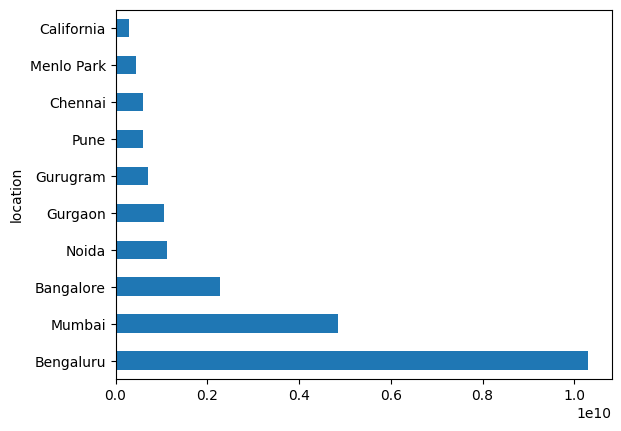

In [158]:
df.groupby('location')['amount'].sum().sort_values(ascending=False).head(10).plot(kind='barh')

<Axes: ylabel='amount_bucket'>

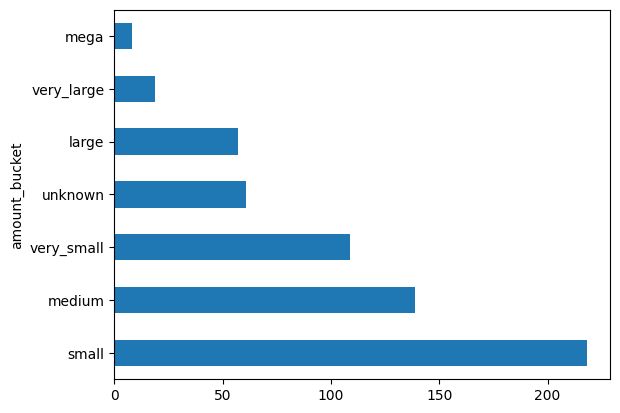

In [159]:
df["amount_bucket"].value_counts().plot(kind='barh')

The small bucket clearly dominates the distribution by deal count.
There are 8 megadeals, representing only a tiny fraction of total deals.
Most deals are concentrated in the lower buckets (very_small, small, medium), with progressively fewer as you move to large, very_large, and mega.
This pattern—many small deals and very few very large ones—is consistent with a long‑tail funding distribution.

# Week 2 Exploration notebook

## Industry Analysis

### Deal Count by Industry


In [160]:
count_industry = df['industry'].value_counts().sort_values(ascending=False).head(20)
count_industry

industry
Consumer Internet    148
Technology            47
Finance               36
E-commerce            32
Healthcare            30
Fin-Tech              24
FinTech               23
IT                    16
EduTech               13
E-Commerce            12
Logistics Tech         8
Food and Beverage      8
Ed-Tech                8
Transportation         7
Automobile             7
Real Estate            6
Transport              6
EdTech                 6
SaaS                   6
Food                   6
Name: count, dtype: int64

### Total funding by Industry

In [161]:
tot_fund_industry = df.groupby('industry')['amount'].sum().sort_values(ascending=False).head(20)
tot_fund_industry

industry
Transportation              3.925282e+09
Consumer Internet           3.496887e+09
Finance                     2.993600e+09
E-commerce                  2.551149e+09
FinTech                     1.477541e+09
Edu-tech                    1.220000e+09
E-Commerce                  9.478900e+08
B2B Platform                9.000000e+08
EduTech                     7.634492e+08
B2B                         5.870000e+08
Fin-Tech                    5.628000e+08
Hospitality                 5.087470e+08
Health and Wellness         4.902000e+08
Technology                  4.208640e+08
Online Food Delivery        3.860000e+08
Automation                  3.000000e+08
Last Mile Transportation    2.833000e+08
Ecommerce                   2.760000e+08
Education                   2.167780e+08
SaaS                        2.020038e+08
Name: amount, dtype: float64

### Average deal size by industry

In [162]:
avg_fund_industry = df.groupby('industry')['amount'].mean().sort_values(ascending=False).head(20)
avg_fund_industry


industry
Transportation              6.542137e+08
Edu-tech                    4.066667e+08
Automation                  3.000000e+08
B2B                         2.935000e+08
B2B Platform                2.250000e+08
E-Tech                      2.000000e+08
Online Food Delivery        1.930000e+08
Technology Provider         1.600000e+08
Last Mile Transportation    1.416500e+08
Agtech                      1.400000e+08
Ecommerce                   1.380000e+08
Hospitality                 1.017494e+08
Food Startup                1.000000e+08
Edutech                     1.000000e+08
Health and Wellness         9.804000e+07
Finance                     9.656774e+07
Software                    8.975000e+07
E-commerce                  8.797065e+07
E-Commerce                  7.899083e+07
FinTech                     6.716097e+07
Name: amount, dtype: float64

### 

### Visuals

<Axes: title={'center': 'Number of Investments by Industry'}, xlabel='Number of Investments', ylabel='Industry'>

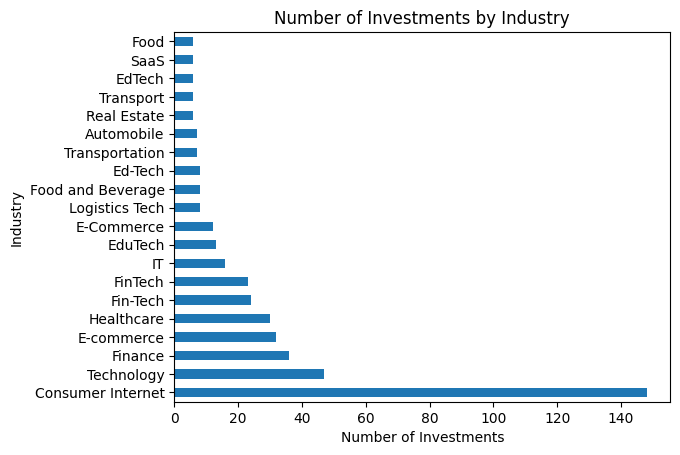

In [163]:
count_industry.plot(kind='barh', title='Number of Investments by Industry', xlabel='Number of Investments', ylabel='Industry')

<Axes: title={'center': 'Total Funding by Industry'}, xlabel='Total Funding Amount', ylabel='Industry'>

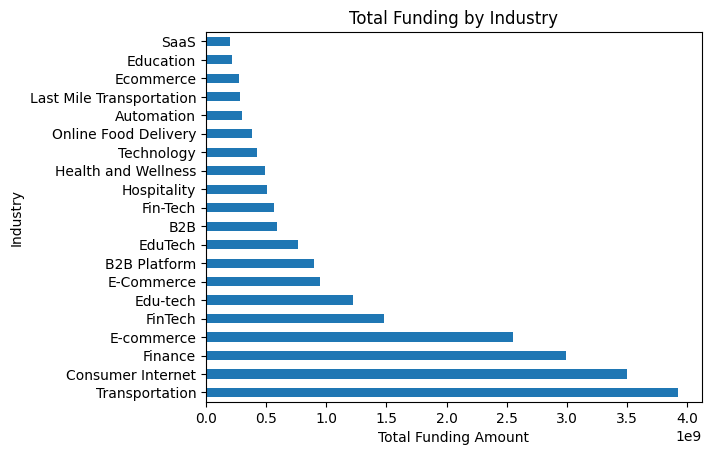

In [164]:
tot_fund_industry.plot(kind='barh', title='Total Funding by Industry', xlabel='Total Funding Amount', ylabel='Industry')

<Axes: title={'center': 'Average Funding by Industry'}, xlabel='Average Funding Amount', ylabel='Industry'>

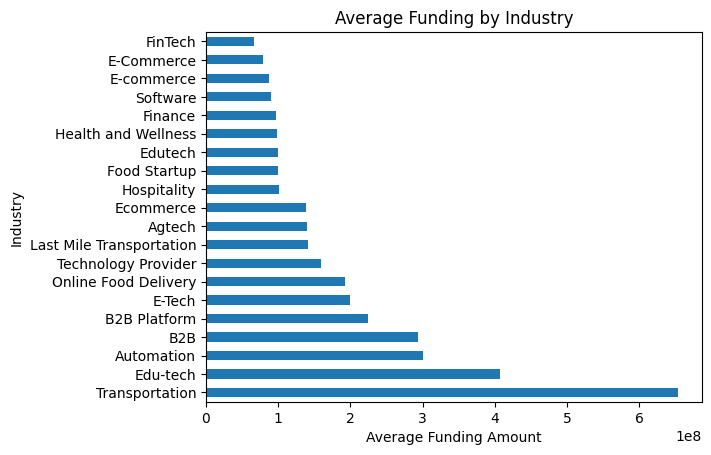

In [165]:
avg_fund_industry.plot(kind='barh', title='Average Funding by Industry', xlabel='Average Funding Amount', ylabel='Industry')

## City Analysis

### Deal count by city

In [166]:
deal_city = df['city_stand'].value_counts().sort_values(ascending=False).head(20)
deal_city

city_stand
bengaluru                  226
gurgaon                    110
mumbai                     101
delhi                       45
pune                        21
chennai                     21
hyderabad                   21
other_international         16
noida                        9
jaipur                       6
ahmedabad                    5
rourkela                     4
bhopal                       2
patna                        2
india us                     2
mumbai bengaluru             2
san francisco bangalore      1
stanford, california,        1
faridabad                    1
singapore and bangalore      1
Name: count, dtype: int64

### Total funding by city


In [167]:
tot_fund_city = df.groupby('city_stand')['amount'].sum().sort_values(ascending=False).head(20)
tot_fund_city

city_stand
bengaluru                  1.289784e+10
mumbai                     4.847825e+09
gurgaon                    1.749592e+09
other_international        1.606239e+09
noida                      1.113358e+09
pune                       6.051742e+08
chennai                    6.032990e+08
delhi                      4.515823e+08
jaipur, rajasthan          2.500000e+08
faridabad                  2.310000e+08
india singapore            2.260000e+08
tulangan                   2.000000e+08
hyderabad                  1.780000e+08
san jose,                  1.350000e+08
india us                   5.150000e+07
ahmedabad                  4.245924e+07
patna                      4.200000e+07
san francisco bangalore    2.500000e+07
haryana                    1.550000e+07
rourkela                   1.000000e+07
Name: amount, dtype: float64

### Visuals

<Axes: title={'center': 'Number of Deals by City'}, xlabel='Number of Deals', ylabel='City'>

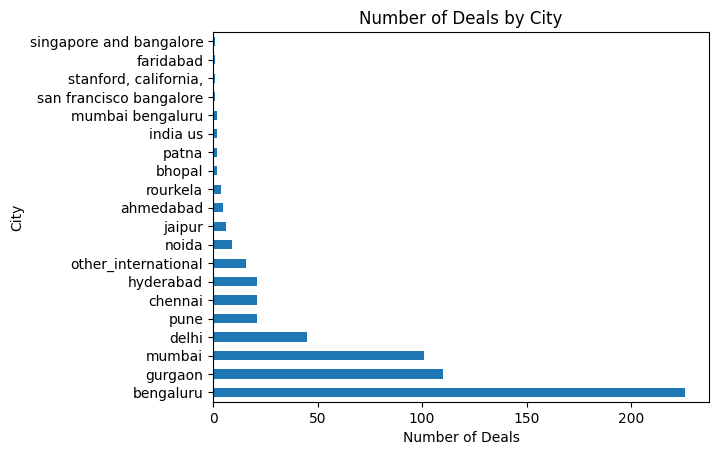

In [168]:
deal_city.plot(kind='barh', title='Number of Deals by City', xlabel='Number of Deals', ylabel='City')

<Axes: title={'center': 'Total Funding by City'}, xlabel='Total Funding Amount', ylabel='City'>

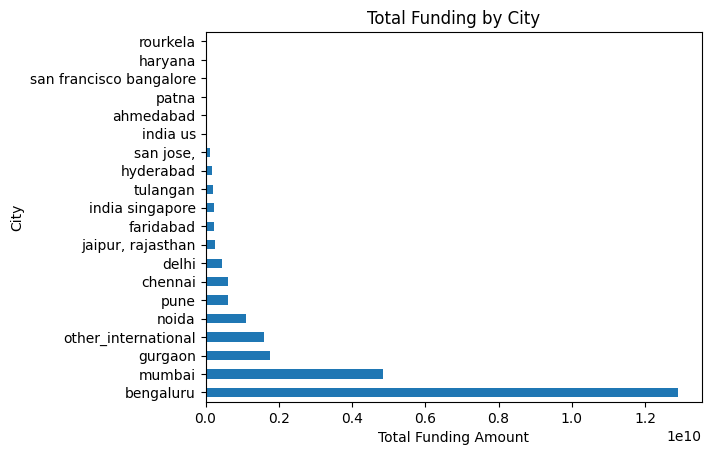

In [169]:
tot_fund_city.plot(kind='barh', title='Total Funding by City', xlabel='Total Funding Amount', ylabel='City')

## Yearly Trend Analysis

### Deal count per year


In [170]:
count_year = df['date'].dt.year.value_counts()
count_year

date
2018.0    346
2020.0    121
2019.0    111
2021.0     29
Name: count, dtype: int64

### total funding per year

In [171]:
tot_fund_year = df.groupby(df['date'].dt.year)['amount'].sum().sort_values(ascending=False)
tot_fund_year

date
2019.0    9.545919e+09
2018.0    8.665903e+09
2020.0    4.045309e+09
2021.0    3.032093e+09
Name: amount, dtype: float64

### visuals

<Axes: title={'center': 'Number of Investments by Year'}, xlabel='Year', ylabel='Number of Investments'>

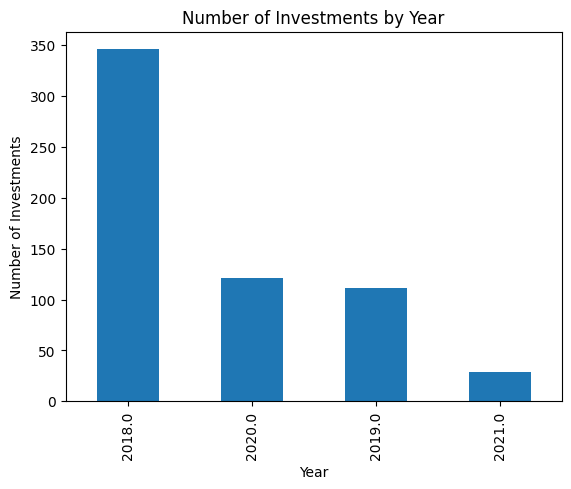

In [172]:
count_year.plot(kind='bar', title='Number of Investments by Year', xlabel='Year', ylabel='Number of Investments')

<Axes: title={'center': 'Total Funding by Year'}, xlabel='Year', ylabel='Total Funding Amount'>

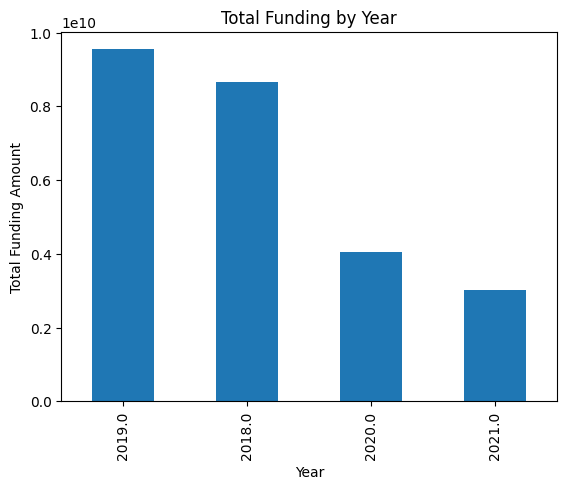

In [173]:
tot_fund_year.plot(kind='bar', title='Total Funding by Year', xlabel='Year', ylabel='Total Funding Amount')

## Investor analysis

### Top investors by deal count

In [174]:
investor_series = df['investor_list'].explode()
count_investor = investor_series.value_counts().sort_values(ascending=False).head(20)
count_investor = count_investor.reset_index()
count_investor.columns = ["investor", "count"]
count_investor


,investor,count
0,Accel Partners,15
1,Y Combinator,14
2,Sequoia Capital India,14
3,Ventureast,13
4,Nexus Venture Partners,13
5,Shunwei Capital,13
6,Beenext,12
7,Kalaari Capital,11
8,Sistema Asia Fund,10
9,Matrix Partners India,9


### visuals


<Axes: title={'center': 'Top Investors by Number of Investments'}, xlabel='Number of Investments', ylabel='Investor'>

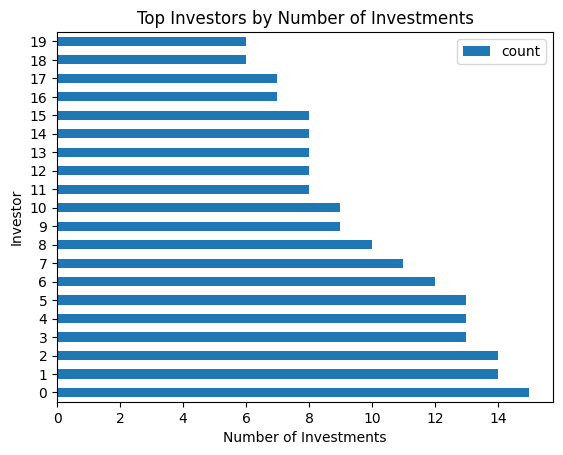

In [175]:
count_investor.plot(kind='barh', title='Top Investors by Number of Investments', xlabel='Number of Investments', ylabel='Investor')

###  Top Investors by Total Amount Invested

In [176]:
from collections import defaultdict
inv_amount = defaultdict(float) # default to 0.0
for _, row in df.iterrows():
    amount = row['amount']
    # print(amount, df['investor_list'])
    if pd.notna(amount):
        for investor in row['investor_list']:
            inv_amount[investor] = inv_amount[investor] + amount
            # print(investor, inv_amount[investor])

inv_amount


defaultdict(float,
            {'Innoven Capital': 731500000.0,
             'SoftBank Vision Fund 2': 300000000.0,
             'Amansa Holdings': 343000000.0,
             'Carmignac': 343000000.0,
             'Falcon Edge Capital': 411000000.0,
             'Goldman Sachs': 347889975.54,
             'Think Investments': 343000000.0,
             'MC Global Edtech': 543000000.0,
             'B Capital': 693000000.0,
             'Baron': 543000000.0,
             'Hindustan Media Ventures': 7400000.0,
             'Sorenson Capital Partners': 140000000.0,
             'Krishtal Advisors Pte Ltd': 8000000.0,
             'Titan Capital': 300000000.0,
             'Accel Partners': 599937020.74,
             'PayU': 89100000.0,
             'SIG Global': 2500000.0,
             'Sequoia Capital': 411500000.0,
             'WaterBridge Ventures': 5000000.0,
             'ON Mauritius': 5380000.0,
             'Tiger Global': 772500000.0,
             'Kora': 250000000.0,
            

In [177]:
tot_inv = pd.DataFrame.from_dict(inv_amount, orient='index', columns=['total_invested'])
tot_inv.sort_values(by='total_invested', ascending=False, inplace=True)
tot_inv.reset_index(inplace=True)
tot_inv.columns = ['investor', 'total_invested']
tot_inv

,investor,total_invested
0,Westbridge Capital,3.900000e+09
1,DST Global,1.565000e+09
2,Walmart Inc,1.200000e+09
3,Kalaari Capital,1.188400e+09
4,Vijay Shekhar Sharma,1.000000e+09
...,...,...
501,Raj Mishra,2.000000e+05
502,founder of AIT Global Inc,2.000000e+05
503,Unnamed angel investors,2.000000e+05
504,Kapil Dev,1.450000e+05


<Axes: title={'center': 'Top Investors by Total Investment Amount'}, xlabel='Total Investment Amount', ylabel='Investor'>

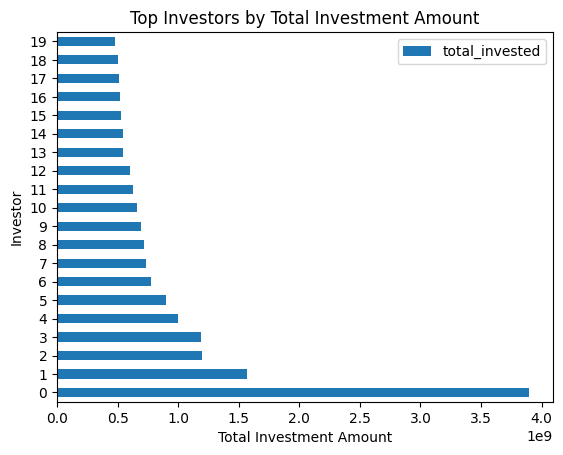

In [178]:
tot_inv.head(20).plot(kind='barh', title='Top Investors by Total Investment Amount', xlabel='Total Investment Amount', ylabel='Investor')

<Axes: title={'center': 'Top Investors by Average Investment Amount'}, xlabel='Average Investment Amount', ylabel='Investor'>

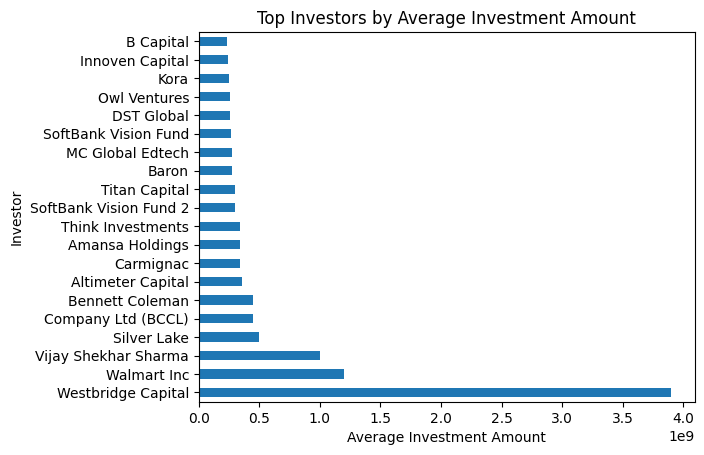

In [179]:
exploded = df.explode('investor_list')
exploded = exploded.dropna(subset=['investor_list'])
exploded.isna().sum()

avg_inv_fund = exploded.groupby('investor_list')['amount'].mean().sort_values(ascending=False).head(20)
avg_inv_fund.plot(kind='barh', title='Top Investors by Average Investment Amount', xlabel='Average Investment Amount', ylabel='Investor')

In [180]:
exploded.groupby('investor_list')['city_stand'].count().sort_values(ascending=False).head(20)

investor_list
Accel Partners                15
Y Combinator                  14
Sequoia Capital India         14
Shunwei Capital               13
Ventureast                    13
Nexus Venture Partners        13
Beenext                       12
Kalaari Capital               11
Sistema Asia Fund             10
Matrix Partners India          9
Falcon Edge                    9
Info Edge (India) Ltd          8
Xiaomi                         8
Tencent                        8
Sequoia India                  8
Omidyar Network                8
Tiger Global Management        7
Stellaris Venture Partners     7
InnoVen Capital                6
Sequoia Capital                6
Name: city_stand, dtype: int64

In [181]:
inv_industry_counts = (exploded.groupby(['investor_list', 'industry']).size().reset_index(name="deal_count"))
inv_top_industries = inv_industry_counts.sort_values(['investor_list', 'deal_count'], ascending=[True, False]).groupby('investor_list').head(3)
inv_top_industries


,investor_list,industry,deal_count
0,021 Capita,Technology,1
1,021 Capital,EduTech,1
2,100 Co-founders Lab,Healthcare,4
3,3one4 Capital,Social Media,1
4,91SpringBoard,Nanotechnology,1
...,...,...,...
701,others.,Professional Network for Women,1
702,the Allana Group,E-commerce,1
703,the IAN Fund,Consumer Internet,4
704,the UK’s Development Finance Institution,NBFC,1


In [182]:
# --- Top industries per investor ---

# counts per (investor, industry)
inv_industry_counts = (
    exploded.groupby(["investor_list", "industry"])
    .size()
    .reset_index(name="deal_count")
)

# for each investor, sort and take top N industries (e.g., N = 3)
N = 3
inv_top_industries = (
    inv_industry_counts
    .sort_values(["investor_list", "deal_count"], ascending=[True, False])
    .groupby("investor_list")
    .head(N)
)

# --- Top cities per investor ---

inv_city_counts = (
    exploded.groupby(["investor_list", "city_stand"])
    .size()
    .reset_index(name="deal_count")
)

inv_top_cities = (
    inv_city_counts
    .sort_values(["investor_list", "deal_count"], ascending=[True, False])
    .groupby("investor_list")
    .head(N)
)

In [183]:
inv_top_industries

,investor_list,industry,deal_count
0,021 Capita,Technology,1
1,021 Capital,EduTech,1
2,100 Co-founders Lab,Healthcare,4
3,3one4 Capital,Social Media,1
4,91SpringBoard,Nanotechnology,1
...,...,...,...
701,others.,Professional Network for Women,1
702,the Allana Group,E-commerce,1
703,the IAN Fund,Consumer Internet,4
704,the UK’s Development Finance Institution,NBFC,1


In [184]:
inv_top_cities

,investor_list,city_stand,deal_count
0,021 Capita,bengaluru,1
1,021 Capital,bengaluru,1
2,100 Co-founders Lab,jaipur,4
3,3one4 Capital,delhi,1
4,91SpringBoard,delhi,1
...,...,...,...
657,others.,gurgaon,1
659,the Allana Group,bengaluru,1
660,the IAN Fund,chennai,4
661,the UK’s Development Finance Institution,chennai,1


## Startup funding profiles

### compute total funding per startup

In [185]:
tot_fund_startup=df.groupby('startup')['amount'].sum().sort_values(ascending=False).head(10)
tot_fund_industry

industry
Transportation              3.925282e+09
Consumer Internet           3.496887e+09
Finance                     2.993600e+09
E-commerce                  2.551149e+09
FinTech                     1.477541e+09
Edu-tech                    1.220000e+09
E-Commerce                  9.478900e+08
B2B Platform                9.000000e+08
EduTech                     7.634492e+08
B2B                         5.870000e+08
Fin-Tech                    5.628000e+08
Hospitality                 5.087470e+08
Health and Wellness         4.902000e+08
Technology                  4.208640e+08
Online Food Delivery        3.860000e+08
Automation                  3.000000e+08
Last Mile Transportation    2.833000e+08
Ecommerce                   2.760000e+08
Education                   2.167780e+08
SaaS                        2.020038e+08
Name: amount, dtype: float64

<Axes: title={'center': 'Top Startups by Total Funding'}, xlabel='Total Funding Amount', ylabel='Startup'>

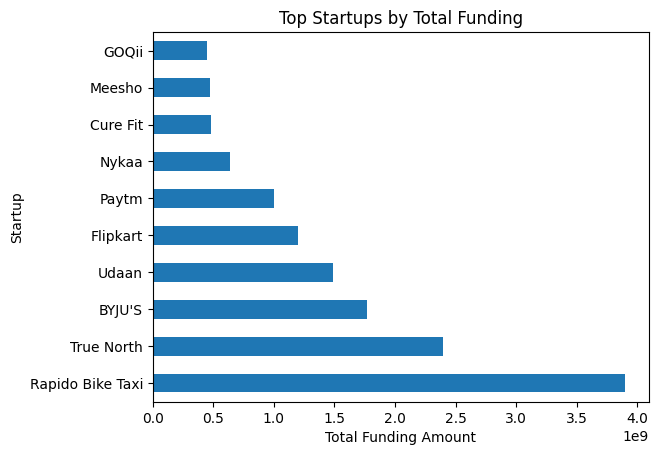

In [186]:
tot_fund_startup.plot(kind='barh', title='Top Startups by Total Funding', xlabel='Total Funding Amount', ylabel='Startup')

In [187]:
tot_startup_rounds=df.groupby('startup').size().reset_index(name='num_rounds').sort_values(by='num_rounds', ascending=False).head(10)
tot_startup_rounds

,startup,num_rounds
207,Nykaa,6
259,Shuttl,6
163,LetsTransport,5
285,Udaan,5
27,BYJU'S,5
50,Cars24,5
280,Trell,5
127,Groww,5
40,Blackbuck,5
307,ZestMoney,5


<Axes: title={'center': 'Top Startups by Number of Funding Rounds'}, xlabel='Number of Funding Rounds', ylabel='Startup'>

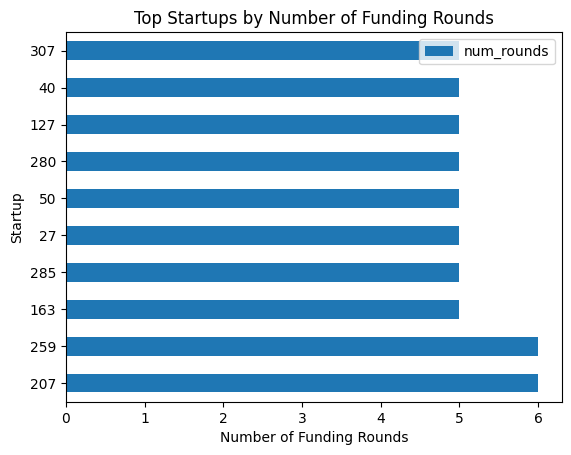

In [188]:
tot_startup_rounds.plot(kind='barh', title='Top Startups by Number of Funding Rounds', xlabel='Number of Funding Rounds', ylabel='Startup')

,min,max
startup,,
Guiddoo,2018,2018
InCred Finance,2018,2018
Roposo,2018,2018
19th mile,2018,2018
1mg,2020,2020
3HCare,2018,2018
3rdFlix,2019,2019
5th Vital,2018,2018
75F,2019,2019


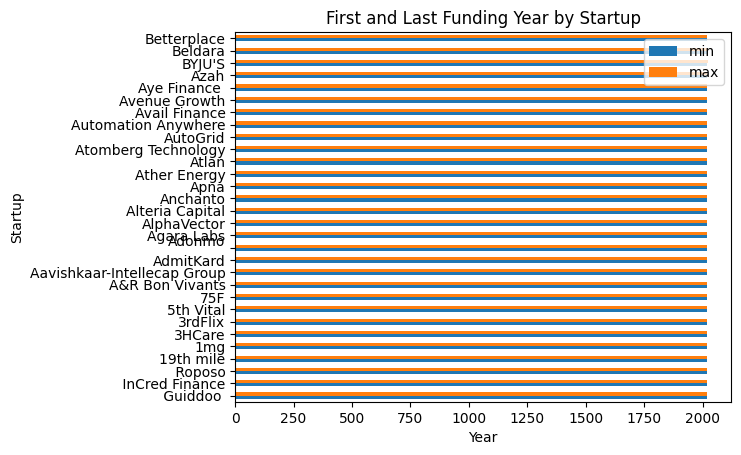

In [195]:
df['year'] = pd.to_datetime(df['date']).dt.year
df['year'] = df['year'].astype('Int64') 
first_last_funding  = df.groupby('startup')['year'].agg(['min', 'max']).head(30)
first_last_funding.plot(kind='barh', title='First and Last Funding Year by Startup', xlabel='Year', ylabel='Startup')
first_last_funding


NameError: name 'plt' is not defined

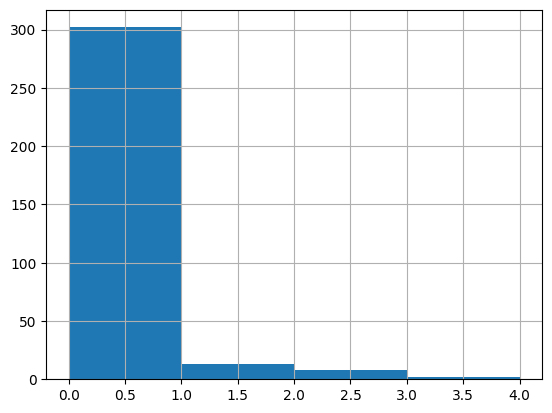

In [198]:
df.columns

Index(['unnamed_0', 'date', 'startup', 'industry', 'location', 'investor',
       'type', 'amount', 'year', 'date_missing', 'type_canonical',
       'investor_list', 'investor_count', 'startup_clean', 'amount_bucket',
       'city_stand', 'z_score', 'zscore_outlier', 'iqr_outlier', 'is_outlier'],
      dtype='object')

In [201]:
agg = (
        df.groupby("startup")
          .agg(
              total_amount=("amount", "sum"),
              first_year=("year", "min"),
              last_year=("year", "max"),
              n_rounds=("amount", "size"),
          )
          .reset_index()
    )
agg["span_years"] = (agg["last_year"] - agg["first_year"] + 1).clip(lower=1)

    # Funding velocity: amount per active year
agg["funding_velocity_per_year"] = agg["total_amount"] / agg["span_years"]
agg

,startup,total_amount,first_year,last_year,n_rounds,span_years,funding_velocity_per_year
0,Guiddoo,800000.0,2018,2018,1,1,800000.0
1,InCred Finance,42000000.0,2018,2018,1,1,42000000.0
2,Roposo,1700000.0,2018,2018,1,1,1700000.0
3,19th mile,720000.0,2018,2018,4,1,720000.0
4,1mg,110000000.0,2020,2020,2,1,110000000.0
...,...,...,...,...,...,...,...
321,leap.club,340000.0,2020,2020,1,1,340000.0
322,mCaffeine,3000000.0,2020,2020,1,1,3000000.0
323,mfine,21400000.0,2020,2021,2,2,10700000.0
324,quizizz,12000000.0,2018,2018,4,1,12000000.0
